In [1]:
import lightgbm as lgb
import numpy as np
import pickle
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def save_pkl(file_dir, data):
    f = open(file_dir,"wb")
    pickle.dump(data, f, protocol=4)
    f.close()
    
def read_pkl(file_dir):
    f = open(file_dir,"rb")
    data = pickle.load(f)
    return data

def get_score(valid_y_exp, pred):
    return mean_absolute_error(pred, valid_y_exp)


In [3]:
df = pd.read_csv("Dataset/AAl_G_Weather_SkewFix_19des-22mar.csv")


In [4]:
df = df.rename(columns={"Recorded":"time","heat_index":"temperature","rh":"humidity","wdir":"wind_direction","wspd":"wind_speed",
                        'NO2': 'NO2_Concentration','NOx': 'NOx_Concentration'})
df['time'] = pd.to_datetime(df['time'])
df.index = df['time']
df['time_week'] = df.index.map(lambda x: x.weekday)
df['time_year'] = df.index.map(lambda x: x.year)
df['time_month'] = df.index.map(lambda x: x.month)
df['time_day'] = df.index.map(lambda x: x.day)
df['time_hour'] = df.index.map(lambda x: x.hour)


In [5]:
Airs = df[["NOx_Concentration","NO2_Concentration",'time_year', 'time_month', 'time_week', 'time_day', 
          'time_hour',"temperature", "pressure", "humidity", "wind_direction", "wind_speed",]].copy()

# Airs = df[["NO2_Concentration", "NOx_Concentration"
#          ]].copy()

In [6]:
Airs = df.drop(columns=["wdir_cardinal","time","SO2","CO","time_month", "time_day", "pressure"])


In [7]:
Airs["NOx_max"]= Airs["NOx_Concentration"].max()
Airs["NOx_min"]= Airs["NOx_Concentration"].min()
Airs["NOx_mean"]= Airs["NOx_Concentration"].mean()
Airs["NO2_max"]= Airs["NO2_Concentration"].max()
Airs["NO2_min"]= Airs["NO2_Concentration"].min()
Airs["NO2_mean"]= Airs["NO2_Concentration"].mean()
Airs = Airs.reset_index(drop=True)
Airs[27:28]
for t in range(len(Airs)-1,-1,-1):
    tmp1 = Airs.loc[t,"time_week"]
    for bt in range(t,-1,-1):
        tmp2 = Airs.loc[bt,"time_week"]
        
        if bt==0:
            bt=-1
            break
        elif tmp1 == tmp2:
            # print(tmp1,tmp2)
            continue
        else:
            # print(t,tmp1,bt,tmp2)
            break
    # print(t,tmp1,bt,tmp2)
    Airs.loc[t,"NOx_max"]=Airs["NOx_Concentration"].iloc[bt+1:t+1].max()
    Airs.loc[t,"NOx_mean"]=Airs["NOx_Concentration"].iloc[bt+1:t+1].mean()
    Airs.loc[t,"NOx_min"]=Airs["NOx_Concentration"].iloc[bt+1:t+1].min()
    Airs.loc[t,"NO2_max"]=Airs["NO2_Concentration"].iloc[bt+1:t+1].max()
    Airs.loc[t,"NO2_mean"]=Airs["NO2_Concentration"].iloc[bt+1:t+1].mean()
    Airs.loc[t,"NO2_min"]=Airs["NO2_Concentration"].iloc[bt+1:t+1].min()
    
Airs.head(30)

,NO2_Concentration,NOx_Concentration,temperature,humidity,wind_direction,wind_speed,time_week,time_year,time_hour,NOx_max,NOx_min,NOx_mean,NO2_max,NO2_min,NO2_mean
0,11.84,18.23,9.0,87.0,260.0,31.0,4,2019,10,18.23,18.23,18.230000,11.84,11.84,11.840000
1,17.29,26.09,9.0,87.0,260.0,33.0,4,2019,10,26.09,18.23,22.160000,17.29,11.84,14.565000
2,21.40,31.80,8.0,93.0,250.0,33.0,4,2019,11,31.80,18.23,25.373333,21.40,11.84,16.843333
3,16.03,28.80,8.0,93.0,250.0,30.0,4,2019,11,31.80,18.23,26.230000,21.40,11.84,16.640000
4,25.11,38.67,8.0,93.0,250.0,24.0,4,2019,12,38.67,18.23,28.718000,25.11,11.84,18.334000
5,23.14,47.60,8.0,100.0,240.0,19.0,4,2019,12,47.60,18.23,31.865000,25.11,11.84,19.135000
6,25.84,44.62,9.0,93.0,230.0,22.0,4,2019,13,47.60,18.23,33.687143,25.84,11.84,20.092857
7,27.64,47.66,9.0,93.0,230.0,20.0,4,2019,13,47.66,18.23,35.433750,27.64,11.84,21.036250
8,25.97,42.50,9.0,100.0,230.0,19.0,4,2019,14,47.66,18.23,36.218889,27.64,11.84,21.584444
9,31.42,53.51,9.0,100.0,230.0,20.0,4,2019,14,53.51,18.23,37.948000,31.42,11.84,22.568000


In [8]:
listing = []
for i in range(35519):
    tmp = Airs.iloc[i]
    tmp = np.hstack((tmp))
    listing.append(tmp)
        
    

In [9]:
NOx_list = Airs['NOx_Concentration'].values
NO2_list = Airs['NO2_Concentration'].values
Y_NOx_list = []
Y_NO2_list = []

X_extend_list = []
for i in range(48,35567):
    Y_NOx_list.append(NOx_list[i])
    Y_NO2_list.append(NO2_list[i])

In [10]:
test_x = []
for i in range(35568,Airs.shape[0]-53):
    tmp = Airs.iloc[i]
    tmp = np.hstack((tmp))
    test_x.append(tmp)

In [11]:
Y_NOx_Test_list = []
Y_NO2_Test_list = []
for i in range(35616,Airs.shape[0]-5):
    Y_NOx_Test_list.append(NOx_list[i])
    Y_NO2_Test_list.append(NO2_list[i])

In [12]:
Y_Test_NOx = np.vstack(Y_NOx_Test_list)
Y_Test_NO2 = np.vstack(Y_NO2_Test_list)
Y_Test_NOx = Y_Test_NOx.flatten()
Y_Test_NO2 = Y_Test_NO2.flatten()
X_Test = np.vstack(test_x)

In [13]:
Y_NOx = np.vstack(Y_NOx_list)
Y_NO2 = np.vstack(Y_NO2_list)
Y_NOx = Y_NOx.flatten()
Y_NO2 = Y_NO2.flatten()
X = np.vstack(listing)

In [65]:
listfeature_name = ['NOx_Concentration','NO2_Concentration']

In [66]:
listfeature_name = ['NOx_Concentration','NO2_Concentration',"time_year", 'time_month',          # feature 0-1# feature 2-6
                    'time_week','time_day','time_hour',
                    'temperature','pressure','humidity', 'wind_direction', 'wind_speed',#"NO2ratio","NOxratio"#"O3_Concentration",
                    ]

In [67]:
listfeature_name = ['NO2_Concentration','NOx_Concentration',"time_year", #'time_month',          # feature 0-1# feature 2-6
                    'time_week',#'time_day',
                    'time_hour',
                    'temperature',#'pressure',
                    'humidity', 'wind_direction', 'wind_speed',#"NO2ratio","NOxratio"#"O3_Concentration",
                    ]

In [14]:
listfeature_name = ['NO2_Concentration','NOx_Concentration',"time_year", #'time_month',          # feature 0-1# feature 2-6
                    'time_week',#'time_day',
                    'time_hour',
                    'temperature',#'pressure',
                    'humidity', 'wind_direction', 'wind_speed',"NOx_max","NOx_mean","NOx_min","NO2_max","NO2_mean",
"NO2_min",   #"NO2ratio","NOxratio"#"O3_Concentration",
                    ]

In [15]:
def train_test(model_param, train_X, test_X, train_Y, test_Y, save_dir):
    time_start = time.time()
    lgb_train = lgb.Dataset(train_X, train_Y)
    lgb_eval = lgb.Dataset(test_X, test_Y, reference=lgb_train)
    params = {
    'task': 'train',
    'verbosity': -1,
    'gpu_use_dp': True,
    'device_type': 'gpu',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'mae'},
    'max_depth': model_param['depth'], #impact on model performance and train time
    'num_leaves': model_param['leaf'],
    'min_data_in_leaf': 20,
    'learning_rate': model_param['lr'],
    'num_threads':7
    # 'feature_fraction': 1, #can be used to speed up training and deal with overfitting
    # 'bagging_fraction': 0.8,
    # 'bagging_freq': 1,
    # 'bagging_seed': 3,
#     'min_sum_hessian_in_leaf': 100,
    }
    evaluation_results  = {}

    gbm = lgb.train(params,
                    train_set = lgb_train,
                    num_boost_round=model_param['tree'],
                    valid_sets=[lgb_train, lgb_eval],
                    valid_names=['Train', 'Valid'],
                    #categorical_feature=2,
                    #evals_result= evaluation_results,
                    #verbose_eval=500,
                    #early_stopping_rounds=3,
                    feature_name = listfeature_name,
                    callbacks=[lgb.early_stopping(stopping_rounds=3),lgb.log_evaluation(period=500),lgb.record_evaluation(eval_result=evaluation_results)]) 

    test_predict = gbm.predict(test_X)
    score = get_score(test_predict, test_Y)
    save_pkl(save_dir, gbm)
    print('running time: ', time.time() - time_start)

    lgb.plot_metric(evaluation_results)
    return score

In [16]:
train_X_NOx, test_X_NOx, train_Y_NOx, test_Y_NOx = train_test_split(X, Y_NOx, test_size=0.2,random_state=42)
print(train_X_NOx.shape, test_X_NOx.shape, train_Y_NOx.shape, test_Y_NOx.shape)

(28415, 15) (7104, 15) (28415,) (7104,)


Training until validation scores don't improve for 3 rounds
[500]	Train's l1: 12.9447	Valid's l1: 13.7182
Early stopping, best iteration is:
[511]	Train's l1: 12.9352	Valid's l1: 13.7149
running time:  2.0420315265655518


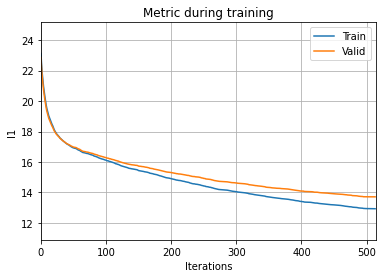

In [17]:
model_param={'lr': 0.1, 'depth': -1, 'tree': 3000, 'leaf': 10}
score = train_test(model_param, train_X_NOx, test_X_NOx, train_Y_NOx, test_Y_NOx, "LightGBM/lightgbm_G_W_test_NOx_24h_10_1.model")

In [20]:
train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2 = train_test_split(X, Y_NO2, test_size=0.2,random_state=42)
print(train_X_NO2.shape, test_X_NO2.shape, train_Y_NO2.shape, test_Y_NO2.shape)

(28415, 15) (7104, 15) (28415,) (7104,)


Training until validation scores don't improve for 3 rounds
[500]	Train's l1: 5.27841	Valid's l1: 5.62155
Early stopping, best iteration is:
[834]	Train's l1: 4.77578	Valid's l1: 5.26143
running time:  2.041998863220215


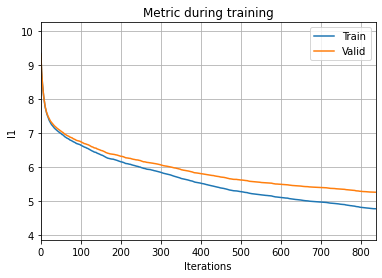

In [21]:
model_param={'lr': 0.1, 'depth': -1, 'tree': 3000, 'leaf': 10}
score = train_test(model_param, train_X_NO2, test_X_NO2, train_Y_NO2, test_Y_NO2, "LightGBM/lightgbm_G_W_test_NO2_24h_10_1.model")

In [18]:
gbmNOx = read_pkl("LightGBM/lightgbm_G_W_test_NOx_24h_10_1.model")
predict_NOx = gbmNOx.predict(X_Test)
score_NOx = get_score(predict_NOx, Y_Test_NOx)
score_NOx

17.57817168308985

In [23]:
gbmNO2 = read_pkl("LightGBM/lightgbm_G_W_test_NO2_24h_10_1.model")
predict_NO2 = gbmNO2.predict(X_Test)
score_NO2 = get_score(predict_NO2, Y_Test_NO2)
score_NO2

7.842769016652278

In [75]:
predictionsDf = pd.DataFrame({"Pred_NO2":predict_NO2,"Pred_NOx":predict_NOx})
predictionsDf = predictionsDf.round(2)
predictionsDf.to_csv("LightGBM/AAl_G_24h_Prediction.csv",index=False)

In [76]:
realDF = pd.DataFrame({"Real_NO2":Y_Test_NO2,"Real_NOx":Y_Test_NOx})
realDF.to_csv("LightGBM/AAl_G_24h_Real.csv",index=False)

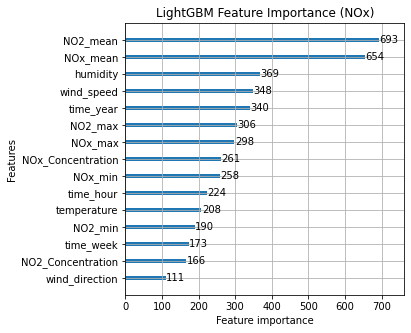

In [19]:
ax = lgb.plot_importance(gbmNOx,figsize=(5,5),importance_type="auto")
plt.title("LightGBM Feature Importance (NOx)")
plt.show()

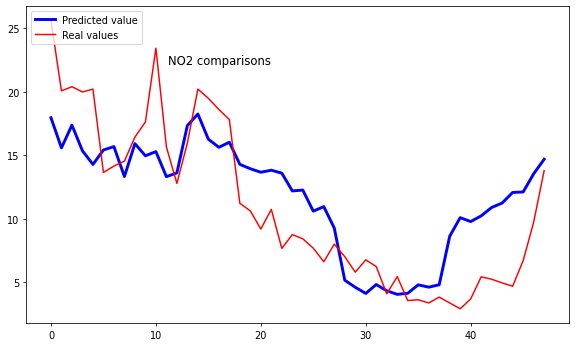

In [78]:
plt.figure(num=None,dpi=70, figsize=(10, 6),facecolor='w', edgecolor='k')
plt.plot(predict_NO2[0:48], "-b",linewidth=3,  label='Predicted value')
plt.plot(Y_Test_NO2[0:48], "-r", label='Real values', )
plt.legend(loc="upper left")
plt.title('NO2 comparisons', x=0.45, y=0.8, loc='right')
plt.show()

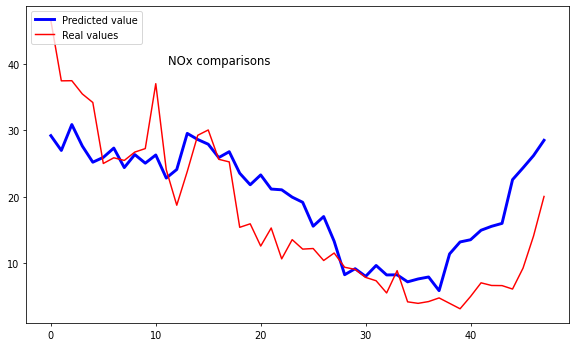

In [80]:
plt.figure(num=None,dpi=70, figsize=(10, 6),facecolor='w', edgecolor='k')
plt.plot(predict_NOx[0:48], "-b",linewidth=3,  label='Predicted value')
plt.plot(Y_Test_NOx[0:48], "-r", label='Real values', )
plt.legend(loc="upper left")
plt.title('NOx comparisons', x=0.45, y=0.8, loc='right')
plt.show()